In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import itertools

# Read in Pickle

In [2]:
X_train = pd.read_pickle('./data/X_train_pickle.pkl')

X_test = pd.read_pickle('./data/X_test_pickle.pkl')

y_train = pd.read_pickle('./data/y_train_pickle.pkl')

y_test = pd.read_pickle('./data/y_test_pickle.pkl')

## KNN

#### Find optimal value for K

In [3]:
k_range = range(1, 13)
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_predict = knn.predict(X_test)
    score = metrics.f1_score(y_test, y_predict, average='weighted')
    k_scores.append(score)
    print("When k={}, f1 score={}".format(k,round(score, 4)))

When k=1, f1 score=0.7893
When k=2, f1 score=0.7871
When k=3, f1 score=0.8039
When k=4, f1 score=0.8
When k=5, f1 score=0.8105
When k=6, f1 score=0.8086
When k=7, f1 score=0.8143
When k=8, f1 score=0.8083
When k=9, f1 score=0.818
When k=10, f1 score=0.8146
When k=11, f1 score=0.8192
When k=12, f1 score=0.8151


In [4]:
high_score = 0
for index, element in enumerate(k_scores):
    if element > high_score:
        high_score = element
        ind = index
        
print("The highest score is {}; when k = {}".format(high_score, ind + 1))

The highest score is 0.819160830626904; when k = 11


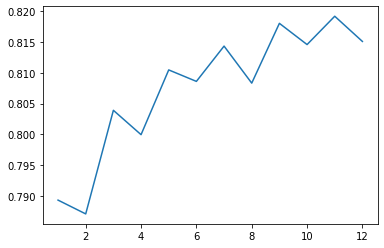

In [5]:
plt.plot(range(1,13),k_scores)

#### The optimal k value is 11; As made evident by the plot.

In [6]:
knn = KNeighborsClassifier(n_neighbors=11)

knn.fit(X_train, y_train)

y_pred_class = knn.predict(X_test)

#### How to plot Confusion Matrix
https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [7]:
# from sklearn.metrics, we use confusion_matrix and pass in the y_test and y_predicted values; saving the result as cm.
cm = confusion_matrix(y_test,y_pred_class)
# because we're aiming to predict a value over/under 50K, we set the classes appropriately. 
classes = ['<=50K', '>50K']

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
#         if normalized, convert the confusion matrix to a float, then divide it by '(cm.sum(axis=1)[:, np.newaxis])' <- what is this?
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

#     Set the plt with the confusion matrix, the colors defined (in this case default), <- What is interpolation?
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes)) 
    plt.xticks(tick_marks, classes, rotation=45) # <- what is rotation?
    plt.yticks(tick_marks, classes)

# what is all of this?
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix, without normalization
[[4101  426]
 [ 631  841]]


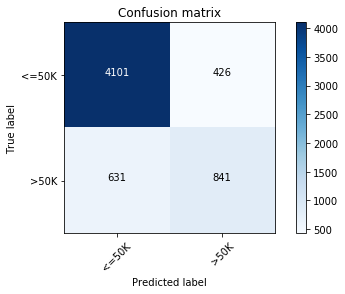

In [9]:
plot_confusion_matrix(cm, classes=classes) #, normalize=False, title='Confusion matrix', cmap=plt.cm.Greens)

In [10]:
round(cm[1][1]/(cm[1][1] + cm[1][0]) * 100, 2)

57.13

The number of Positives that were correctly identified are 57% of the actual Positives that exist in the dataset. Therefore, KNN is not the best classification algorithm to use in this case. This is also known as Recall.

We want to use Recall as a way to compare the effectiveness of different algorithms because we would rather falsely predict a lower salary of an individual(False Negatives), so that they could adequately prepare themselves financially. We would not want to falsely predict higher salaries for individuals, so that they will not have to deal with financial complications(False Positives).